#### Exile on Online Opposition

Examine the effect of exile on percentage of tweets on repression of Venezuela government.

ESBERG, J., & SIEGEL, A. (2023). How Exile Shapes Online Opposition: Evidence from Venezuela. American Political Science Review, 117(4), 1361-1378.

In [1]:
# load gpytoch and other packages
import torch
import numpy as np
import pandas as pd
import gpytorch
from scipy.stats import norm
from matplotlib import pyplot as plt
from gpytorch.means import ZeroMean, LinearMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel
from datetime import datetime

torch.set_default_dtype(torch.float64)
torch.manual_seed(12345)

we first implement GPR for right panel of figure 4.

In [2]:
# read data
data = pd.read_csv("./data/exile.csv")
data = data[["perc_repression", "lead_lags","month","num_tweets", "date_of_exile", "actor.id"]]
data = data[~data.lead_lags.isna()]

def diff_month(d1, d2):
    d1 = datetime.strptime(d1,"%Y-%m-%d")
    d2 = datetime.strptime(d2,"%Y-%m-%d")
    return (d1.year - d2.year) * 12 + d1.month - d2.month

# xs: unit id, month, log_num_tweets, dummies for lead_lags
xs = data.month.apply(lambda x: diff_month(x,"2013-01-01"))
xs = torch.tensor(np.hstack((data["actor.id"].astype('category').cat.codes.values.reshape((-1,1)),\
                    xs.values.reshape((-1,1)),
                    np.log(data.num_tweets.values+1).reshape((-1,1)), \
                    pd.get_dummies(data['lead_lags']).values))).double()
ys = torch.tensor(data.perc_repression.values).double()

we build a Gaussian process regression model with a linear mean function and an automatic relevance determination RBF kernel:
$$
f(t,D) \sim\mathcal{GP}(\beta x,K)
$$

In [3]:
from gpytorch.means import Mean
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class ConstantVectorMean(Mean):
    def __init__(self, n, prior=None, batch_shape=torch.Size(), **kwargs):
        super().__init__()
        self.batch_shape = batch_shape
        self.register_parameter(name="constantvector",\
                 parameter=torch.nn.Parameter(torch.zeros(*batch_shape, n)))
    
    def forward(self, input):
        return self.constantvector[input.long()]

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=False)
        super(GPModel, self).__init__(variational_strategy)
        # linear mean
        self.mean_module = LinearMean(input_size=(inducing_points.size(1)-2), bias=False)
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=(inducing_points.size(1)-2)))
        self.t_covar_module = ScaleKernel(RBFKernel(active_dims=[0])*RBFKernel(active_dims=[1]))

    def forward(self, x):
        mean_x = self.mean_module(x[:,2:])
        covar_x = self.covar_module(x[:,2:]) + self.t_covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [4]:
from torch.utils.data import TensorDataset, DataLoader

inducing_points = xs[np.random.choice(xs.size(0),1000,replace=False),:]
model = GPModel(inducing_points=inducing_points).double()
likelihood = GaussianLikelihood().double()

train_dataset = TensorDataset(xs, ys)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# initialize model parameters
model.t_covar_module.base_kernel.kernels[0].raw_lengthscale.require_grad = False
model.t_covar_module.base_kernel.kernels[0].lengthscale = 0.1
model.t_covar_module.raw_outputscale.require_grad = False
model.t_covar_module.outputscale = 1.
model.covar_module.raw_outputscale.requires_grad = False
model.covar_module.outputscale = 1.
likelihood.noise = 1.

# train model
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': list(set(model.parameters()) - \
                {model.t_covar_module.base_kernel.kernels[0].raw_lengthscale,\
                model.t_covar_module.raw_outputscale,\
                model.covar_module.raw_outputscale})},
    {'params': likelihood.parameters()},
], lr=0.05)

# "Loss" for GPs
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=ys.size(0))

num_epochs = 20
for i in range(num_epochs):
    for j, (x_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()
        if j % 50:
            print('Epoch %d Iter %d - Loss: %.3f' % (i + 1, j+1, loss.item()))


/Users/yahoo/anaconda3/lib/python3.7/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Epoch 1 Iter 2 - Loss: 39.351
Epoch 1 Iter 3 - Loss: 33.693
Epoch 1 Iter 4 - Loss: 32.053
Epoch 1 Iter 5 - Loss: 37.892
Epoch 1 Iter 6 - Loss: 24.696
Epoch 1 Iter 7 - Loss: 31.402
Epoch 1 Iter 8 - Loss: 33.710
Epoch 1 Iter 9 - Loss: 20.359
Epoch 1 Iter 10 - Loss: 23.379
Epoch 1 Iter 11 - Loss: 25.819
Epoch 1 Iter 12 - Loss: 23.780
Epoch 1 Iter 13 - Loss: 28.216
Epoch 1 Iter 14 - Loss: 19.056
Epoch 1 Iter 15 - Loss: 18.123
Epoch 1 Iter 16 - Loss: 21.825
Epoch 1 Iter 17 - Loss: 14.981
Epoch 1 Iter 18 - Loss: 23.555
Epoch 1 Iter 19 - Loss: 19.103
Epoch 1 Iter 20 - Loss: 18.999
Epoch 1 Iter 21 - Loss: 21.854
Epoch 1 Iter 22 - Loss: 20.953
Epoch 1 Iter 23 - Loss: 49.937
Epoch 2 Iter 2 - Loss: 14.511
Epoch 2 Iter 3 - Loss: 19.490
Epoch 2 Iter 4 - Loss: 20.817
Epoch 2 Iter 5 - Loss: 19.124
Epoch 2 Iter 6 - Loss: 14.363
Epoch 2 Iter 7 - Loss: 15.990
Epoch 2 Iter 8 - Loss: 15.499
Epoch 2 Iter 9 - Loss: 16.187
Epoch 2 Iter 10 - Loss: 17.733
Epoch 2 Iter 11 - Loss: 17.958
Epoch 2 Iter 12 - Loss: 

In [5]:
# set model and likelihood to evaluation mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out = model(xs)
    mu_f = out.mean.numpy()
    lower, upper = out.confidence_region()

# store results
results = pd.DataFrame({"gpr_mean":mu_f})
results['true_y'] = ys
results['gpr_lwr'] = lower
results['gpr_upr'] = upper
results['month'] = xs[:,1].numpy().astype(int)
results['unit'] = xs[:,0].numpy().astype(int)
results.to_csv("./results/exile_fitted_gpr.csv",index=False) #save to file

In [6]:
model.eval()
likelihood.eval()

# number of empirically sample 
n_samples = 100
x_grad = np.zeros((xs.size(0),xs.size(1)))
sampled_dydtest_x = np.zeros((n_samples, xs.size(0),xs.size(1)))

# we proceed in small batches of size 100 for speed up
for i in range(xs.size(0)//100):
    with gpytorch.settings.fast_pred_var():
        test_x = xs[(i*100):(i*100+100)].clone().detach().requires_grad_(True)
        observed_pred = likelihood(model(test_x))
        dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
        x_grad[(i*100):(i*100+100)] = dydtest_x

        sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
        sampled_dydtest_x[:,(i*100):(i*100+100),:] = torch.stack([torch.autograd.grad(pred.sum(), \
                                    test_x, retain_graph=True)[0] for pred in sampled_pred])
        
# last 100 rows
with gpytorch.settings.fast_pred_var():
    test_x = xs[(100*i+100):].clone().detach().requires_grad_(True)
    observed_pred = likelihood(model(test_x))
    dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
    x_grad[(100*i+100):] = dydtest_x

    sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
    sampled_dydtest_x[:,(100*i+100):,:] = torch.stack([torch.autograd.grad(pred.sum(),\
                                     test_x, retain_graph=True)[0] for pred in sampled_pred])
    

In [7]:
est_std = np.sqrt(sampled_dydtest_x.mean(1).std(0)**2 + \
                  sampled_dydtest_x.std(1).mean(0)**2).round(decimals=5)
covariate_names = ["time","log_num_tweets"]
for tmp in pd.get_dummies(data['lead_lags']).columns.tolist():
    covariate_names.append("beta "+tmp)
results = pd.DataFrame({"x": covariate_names, \
                        'est_mean': x_grad.mean(axis=0)[1:],
                        'est_std': est_std[1:]})
results["t"] = results['est_mean'].values/results['est_std'].values
results["pvalue"] = 1 - norm.cdf(np.abs(results["t"].values))
print(results)

                    x  est_mean  est_std          t        pvalue
0                time  0.017603  0.16051   0.109666  4.563370e-01
1      log_num_tweets  0.099491  0.63777   0.155999  4.380169e-01
2             beta -2 -0.789271  0.34547  -2.284631  1.116724e-02
3             beta -3 -0.177307  0.28687  -0.618075  2.682629e-01
4             beta -4  0.868958  0.25187   3.450024  2.802683e-04
5             beta -5  1.038516  0.19398   5.353728  4.308008e-08
6             beta -6  1.118578  0.26173   4.273788  9.608995e-06
7              beta 0  1.945824  0.18287  10.640477  0.000000e+00
8              beta 1  3.098768  0.09028  34.323974  0.000000e+00
9             beta 10  1.907258  0.12416  15.361295  0.000000e+00
10            beta 11  2.634853  0.07014  37.565631  0.000000e+00
11             beta 2  2.148635  0.38840   5.532017  1.582846e-08
12             beta 3  3.635183  0.14630  24.847458  0.000000e+00
13             beta 4  1.435049  0.04991  28.752738  0.000000e+00
14        

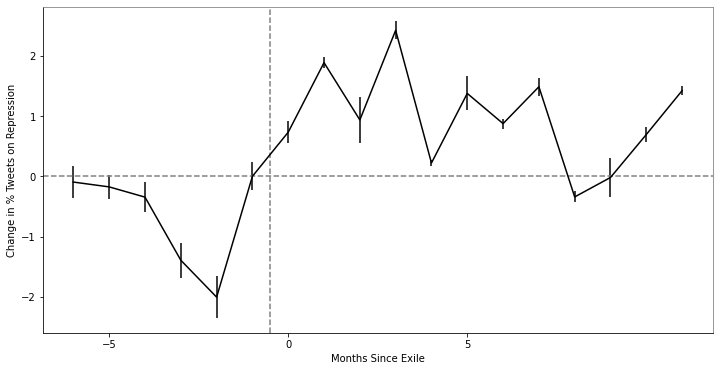

In [8]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))

plot_est_mean = []
plot_est_std = []
for i in range(-6,12):
    if i==-7:
        plot_est_mean.append(results[results.x==("beta pre")].est_mean.values[0])
        plot_est_std.append(results[results.x==("beta pre")].est_std.values[0])
    elif i==12:
        plot_est_mean.append(results[results.x==("beta post")].est_mean.values[0])
        plot_est_std.append(results[results.x==("beta post")].est_std.values[0])
    elif i==-1:
        plot_est_mean.append(results[results.x==("beta month_before")].est_mean.values[0])
        plot_est_std.append(results[results.x==("beta month_before")].est_std.values[0])
    else:
        plot_est_mean.append(results[results.x==("beta "+str(i))].est_mean.values[0])
        plot_est_std.append(results[results.x==("beta "+str(i))].est_std.values[0])
ax.errorbar([i  for i in range(-6,12)], np.array(plot_est_mean)-plot_est_mean[5], yerr=plot_est_std, fmt="k", ecolor="k")
ax.axvline(x=-0.5, ls="--", color="gray")
ax.axhline(y=0, ls="--", color="gray")
ax.set_xlabel("Months Since Exile")
ax.set_ylabel("Change in % Tweets on Repression")
ax.set_xticks(range(-5,10,5))
ax.spines['top'].set_color('gray')
ax.spines['right'].set_color('gray')

next we estimate effect of exile on percentage of repression for left panel of figure 4.

In [9]:
# read data
data = pd.read_csv("./data/exile.csv")
data = data[["perc_repression", "exile", "month","num_tweets", "date_of_exile", "actor.id"]]

def diff_month(d1, d2):
    d1 = datetime.strptime(d1,"%Y-%m-%d")
    d2 = datetime.strptime(d2,"%Y-%m-%d")
    return (d1.year - d2.year) * 12 + d1.month - d2.month

# xs: unit id, month, log_num_tweets, exile
xs = data.month.apply(lambda x: diff_month(x,"2013-01-01"))
xs = torch.tensor(np.hstack((data["actor.id"].astype('category').cat.codes.values.reshape((-1,1)),\
                    xs.values.reshape((-1,1)),
                    np.log(data.num_tweets.values+1).reshape((-1,1)), \
                    data['exile'].values.reshape((-1,1))=="yes")))
ys = torch.tensor(data.perc_repression.values).double()

In [10]:
from gpytorch.means import Mean
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=False)
        super(GPModel, self).__init__(variational_strategy)
        # linear mean
        self.mean_module = LinearMean(input_size=(inducing_points.size(1)-2), bias=False)
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=(inducing_points.size(1)-2)))
        self.t_covar_module = ScaleKernel(RBFKernel(active_dims=[0])*RBFKernel(active_dims=[1,2]))

    def forward(self, x):
        mean_x = self.mean_module(x[:,2:])
        covar_x =  self.t_covar_module(x) # self.covar_module(x[:,2:]) +
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [11]:
inducing_points = xs[np.random.choice(xs.size(0),1000,replace=False),:]
model = GPModel(inducing_points=inducing_points).double()
likelihood = GaussianLikelihood().double()

train_dataset = TensorDataset(xs, ys)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# initialize model parameters
model.t_covar_module.base_kernel.kernels[0].raw_lengthscale.require_grad = False
model.t_covar_module.base_kernel.kernels[0].lengthscale = 0.1
model.t_covar_module.outputscale = 1.
likelihood.noise = 1.

# train model
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': list(set(model.parameters()) - \
                {model.t_covar_module.base_kernel.kernels[0].raw_lengthscale,\
                model.t_covar_module.raw_outputscale})},
    {'params': likelihood.parameters()},
], lr=0.05)

# "Loss" for GPs
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=ys.size(0))

num_epochs = 10
for i in range(num_epochs):
    for j, (x_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()
        if j % 50:
            print('Epoch %d Iter %d - Loss: %.3f' % (i + 1, j+1, loss.item()))


Epoch 1 Iter 2 - Loss: 24.358
Epoch 1 Iter 3 - Loss: 41.147
Epoch 1 Iter 4 - Loss: 22.448
Epoch 1 Iter 5 - Loss: 26.057
Epoch 1 Iter 6 - Loss: 27.396
Epoch 1 Iter 7 - Loss: 26.668
Epoch 1 Iter 8 - Loss: 32.283
Epoch 1 Iter 9 - Loss: 24.489
Epoch 1 Iter 10 - Loss: 26.157
Epoch 1 Iter 11 - Loss: 35.393
Epoch 1 Iter 12 - Loss: 24.813
Epoch 1 Iter 13 - Loss: 25.656
Epoch 1 Iter 14 - Loss: 21.561
Epoch 1 Iter 15 - Loss: 22.151
Epoch 1 Iter 16 - Loss: 26.332
Epoch 1 Iter 17 - Loss: 26.299
Epoch 1 Iter 18 - Loss: 20.866
Epoch 1 Iter 19 - Loss: 15.895
Epoch 1 Iter 20 - Loss: 19.438
Epoch 1 Iter 21 - Loss: 12.574
Epoch 1 Iter 22 - Loss: 16.598
Epoch 1 Iter 23 - Loss: 17.486
Epoch 2 Iter 2 - Loss: 13.914
Epoch 2 Iter 3 - Loss: 14.467
Epoch 2 Iter 4 - Loss: 19.594
Epoch 2 Iter 5 - Loss: 15.532
Epoch 2 Iter 6 - Loss: 11.005
Epoch 2 Iter 7 - Loss: 15.413
Epoch 2 Iter 8 - Loss: 15.069
Epoch 2 Iter 9 - Loss: 13.608
Epoch 2 Iter 10 - Loss: 15.109
Epoch 2 Iter 11 - Loss: 13.826
Epoch 2 Iter 12 - Loss: 

In [12]:
# set model and likelihood to evaluation mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out = model(xs)
    mu_f = out.mean.numpy()
    lower, upper = out.confidence_region()

# store results
results = pd.DataFrame({"gpr_mean":mu_f})
results['true_y'] = ys
results['gpr_lwr'] = lower
results['gpr_upr'] = upper
results['month'] = xs[:,1].numpy().astype(int)
results['unit'] = xs[:,0].numpy().astype(int)
results.to_csv("./results/exile_fitted_gpr.csv",index=False) #save to file

In [13]:
model.eval()
likelihood.eval()

# number of empirically sample 
n_samples = 100
x_grad = np.zeros((xs.size(0),xs.size(1)))
sampled_dydtest_x = np.zeros((n_samples, xs.size(0),xs.size(1)))

# we proceed in small batches of size 100 for speed up
for i in range(xs.size(0)//100):
    with gpytorch.settings.fast_pred_var():
        test_x = xs[(i*100):(i*100+100)].clone().detach().requires_grad_(True)
        observed_pred = likelihood(model(test_x))
        dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
        x_grad[(i*100):(i*100+100)] = dydtest_x

        sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
        sampled_dydtest_x[:,(i*100):(i*100+100),:] = torch.stack([torch.autograd.grad(pred.sum(), \
                                    test_x, retain_graph=True)[0] for pred in sampled_pred])
        
# last 100 rows
with gpytorch.settings.fast_pred_var():
    test_x = xs[(100*i+100):].clone().detach().requires_grad_(True)
    observed_pred = likelihood(model(test_x))
    dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
    x_grad[(100*i+100):] = dydtest_x

    sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
    sampled_dydtest_x[:,(100*i+100):,:] = torch.stack([torch.autograd.grad(pred.sum(),\
                                     test_x, retain_graph=True)[0] for pred in sampled_pred])
    

In [14]:
est_std = np.sqrt(sampled_dydtest_x.mean(1).std(0)**2 + \
                  sampled_dydtest_x.std(1).mean(0)**2).round(decimals=5)

covariate_names = ["time","log_num_tweets"]
results = pd.DataFrame({"x": covariate_names, \
                        'est_mean': x_grad.mean(axis=0)[1:3],
                        'est_std': est_std[1:3]})
results["t"] = results['est_mean'].values/results['est_std'].values
results["pvalue"] = 1 - norm.cdf(np.abs(results["t"].values))
print(results)

                x  est_mean  est_std          t    pvalue
0            time  0.015387  0.25462   0.060430  0.475907
1  log_num_tweets  0.926189  0.03508  26.402199  0.000000


In [15]:
model.eval()
likelihood.eval()

# copy training tesnor to test tensors and set exile to 1 and 0
test_x1 = xs.clone().detach().requires_grad_(False)
test_x1[:,3] = 1
test_x0 = xs.clone().detach().requires_grad_(False)
test_x0[:,3] = 0

# in eval mode the forward() function returns posterioir
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out1 = likelihood(model(test_x1))
    out0 = likelihood(model(test_x0))

# compute ATE and its uncertainty
effect = out1.mean.numpy().mean() - out0.mean.numpy().mean()
effect_std = np.sqrt((out1.mean.numpy().mean()+out0.mean.numpy().mean())) / np.sqrt(xs.size()[0])
BIC = (1+1+2+1)*\
    torch.log(torch.tensor(xs.size()[0])) + 2*loss*xs.size(0)/1024
print("ATE: {:0.3f} +- {:0.3f}\n".format(effect, effect_std))
print("model evidence: {:0.3f} \n".format(-loss*xs.size(0)/1024))
print("BIC: {:0.3f} \n".format(BIC))

ATE: 2.809 +- 0.021

model evidence: -84.446 

BIC: 219.036 

